In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wir setzen ein whitegrid-Theme mit größerer Schrift
sns.set_theme(style="whitegrid", font_scale=1.1)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# ------------------------- SCHRITT 1: CSV-EINLESEN ----------------------------
csv_filename = "fahrzeug_zusammenfassung2.csv"
if not os.path.exists(csv_filename):
    raise FileNotFoundError(f"CSV-Datei '{csv_filename}' nicht vorhanden.")

df = pd.read_csv(csv_filename, delimiter=";", encoding="utf-8-sig", decimal=",")
print("=== Schritt 1: Erste 10 Zeilen der CSV ===")
print(df.head(10))

# Falls es noch keinen 'timestamp' gibt, erzeugen wir ihn
if 'timestamp' not in df.columns:
    df['timestamp'] = (
        (df['num_week'] - 1) * 7 * 24 * 60 +
        (df['week_day'] - 1) * 24 * 60 +
        df['day_hour'] * 60 +
        df['hour_minute']
    )
df.sort_values(['company_id', 'id', 'timestamp'], inplace=True)
print("\nTimestamp: min =", df['timestamp'].min(), "max =", df['timestamp'].max())

=== Schritt 1: Erste 10 Zeilen der CSV ===
           id  company_id economic_sector  vehicle_size  num_week  week_day  \
0  1106000461      100800    CONSTRUCTION             4         1         1   
1  1106000461      100800    CONSTRUCTION             4         1         1   
2  1106000461      100800    CONSTRUCTION             4         1         1   
3  1106000461      100800    CONSTRUCTION             4         1         1   
4  1106000461      100800    CONSTRUCTION             4         1         1   
5  1106000461      100800    CONSTRUCTION             4         1         1   
6  1106000461      100800    CONSTRUCTION             4         1         1   
7  1106000461      100800    CONSTRUCTION             4         1         1   
8  1106000461      100800    CONSTRUCTION             4         1         1   
9  1106000461      100800    CONSTRUCTION             4         1         1   

   day_hour  hour_minute  distance  avg_speed  Fahrend  ParkendFirma  \
0         0    

In [ ]:
# ------------------- SCHRITT 2: PARAMETER, VARIANTEN & OPTIONEN ----------------
"""
Hier werden alle relevanten Parameter festgelegt:
- WAITING_THRESHOLD: Ab welchem SoC-Anteil (z. B. 20%) das Fahrzeug in die Warteschlange geht
- LOADING_THRESHOLD: Ab welchem SoC-Anteil (z. B. 50%) das Fahrzeug sofort zu laden versucht
- battery_variants, consumption_variants: Batteriekapazitäten und Verbrauchswerte
- charger_powers: mögliche Laderleistungen
- ENABLE_WAITING: ob wir Warteschlangen erlauben
- TARGET_COMPANIES: Firmen, die wir visualisieren
- FIG_WIDTH, FIG_HEIGHT, ...: Plot-Einstellungen
"""

BATTERY_VARIANT_INDEX = 1
CONSUMPTION_VARIANT_INDEX = 1

WAITING_THRESHOLD = 0.3     # Ab welchem SoC-Anteil ein Fahrzeug in die Warteschlange kommt
LOADING_THRESHOLD = 0.7     # Ab welchem SoC-Anteil ein Fahrzeug sofort lädt

battery_variants = {
    1: [52, 79],
    2: [52, 77],
    3: [118, 118],
    4: [63.8, 63.8],
    5: [621, 621]
}

consumption_variants = {
    1: [16.6, 15.1],
    2: [16.1, 15.7],
    3: [16.5, 16.5],
    4: [19.9, 19.9],
    5: [119, 119]
}

charger_powers = [3.7, 11.0, 22.0, 50.0]

MIN_SOC_ALLOWED = 0
ENABLE_WAITING = True

TARGET_COMPANIES = [100100, 100600, 100700, 100800]
TARGET_COMPANY = TARGET_COMPANIES[0]

BAR_PALETTE = "Blues"

# Plot-Einstellungen
FIG_WIDTH = 14
FIG_HEIGHT = 10
SHOW_LOAD_CURVE = True
LOAD_CURVE_COLOR = "black"
LOAD_CURVE_LINEWIDTH = 2

print("\n=== Schritt 2: Parameter ===")
print("BATTERY_VARIANT_INDEX =", BATTERY_VARIANT_INDEX)
print("CONSUMPTION_VARIANT_INDEX =", CONSUMPTION_VARIANT_INDEX)
print("WAITING_THRESHOLD =", WAITING_THRESHOLD)
print("LOADING_THRESHOLD =", LOADING_THRESHOLD)
print("ENABLE_WAITING =", ENABLE_WAITING)
print("TARGET_COMPANIES =", TARGET_COMPANIES)

def get_consumption(vehicle_size: int, km: float) -> float:
    """
    Gibt den kWh-Verbrauch für 'km' zurück.
    consumption_variants[vehicle_size][CONSUMPTION_VARIANT_INDEX] => kWh/100km
    """
    cons_per_100km = consumption_variants[vehicle_size][CONSUMPTION_VARIANT_INDEX]
    return (cons_per_100km / 100.0) * km


=== Schritt 2: Parameter ===
BATTERY_VARIANT_INDEX = 1
CONSUMPTION_VARIANT_INDEX = 1
WAITING_THRESHOLD = 0.3
LOADING_THRESHOLD = 0.7
ENABLE_WAITING = True
TARGET_COMPANIES = [100100, 100600, 100700, 100800]


In [4]:
# ---------------- SCHRITT 3: DISTANZBERECHNUNG PRO MINUTE -----------------------
df['distance_minute'] = np.where(
    (df['Fahrend'] == 1) & (df['ParkendFirma'] == 0) & (df['ParkendRemote'] == 0),
    df['avg_speed'] / 60.0,
    0.0
)
print("\n=== Schritt 3: distance_minute ===")
print(df[['timestamp','avg_speed','Fahrend','ParkendFirma','ParkendRemote','distance_minute']].head(10))

debug_rows = df[(df['Fahrend'] == 1) & (df['avg_speed'] > 0) & (df['distance_minute'] == 0)]
if not debug_rows.empty:
    print("\n*** WARNUNG: Fahrend=1, speed>0 aber distance_minute=0 ***")
    print(debug_rows)
else:
    print("\nDebug: Keine Inkonsistenzen gefunden.")



=== Schritt 3: distance_minute ===
        timestamp  avg_speed  Fahrend  ParkendFirma  ParkendRemote  \
302400          0        0.0        0             1              0   
302401          1        0.0        0             1              0   
302402          2        0.0        0             1              0   
302403          3        0.0        0             1              0   
302404          4        0.0        0             1              0   
302405          5        0.0        0             1              0   
302406          6        0.0        0             1              0   
302407          7        0.0        0             1              0   
302408          8        0.0        0             1              0   
302409          9        0.0        0             1              0   

        distance_minute  
302400              0.0  
302401              0.0  
302402              0.0  
302403              0.0  
302404              0.0  
302405              0.0  
302406     

In [ ]:
# --------------- SCHRITT 4: INTERVALLE & EREIGNISSE ABLEITEN --------------------
"""
Bilden von Fahr-/Park-Intervalle und bestimmen 'arrival_firma', 'departure' etc.
"""
def mode(fahr, pfirma, premote):
    """ Bestimmt 'driving' vs. 'parken' vs. 'unknown'. """
    if fahr == 1:
        return 'driving'
    elif pfirma == 1 or premote == 1:
        return 'parken'
    else:
        return 'unknown'

events = []
intervals = []

grouped = df.groupby(['company_id','id'])
for (c_id, v_id), group in grouped:
    group = group.sort_values('timestamp')
    if group.empty:
        continue

    prev_row = None
    interval_start = None
    distance_acc = 0.0

    def finalize_interval(st_t, en_t, m_str, distv):
        intervals.append({
            'company_id': c_id,
            'vehicle_id': v_id,
            'start_time': st_t,
            'end_time': en_t,
            'mode': m_str,
            'distance_sum': distv
        })

    for idx, row in group.iterrows():
        t   = row['timestamp']
        fa  = row['Fahrend']
        pf  = row['ParkendFirma']
        pr  = row['ParkendRemote']
        dist= row['distance_minute']

        if prev_row is None:
            interval_start = t
            interval_mode  = mode(fa, pf, pr)
            distance_acc   = dist
            prev_row       = row
            continue

        old_mode = mode(prev_row['Fahrend'], prev_row['ParkendFirma'], prev_row['ParkendRemote'])
        new_mode = mode(fa, pf, pr)

        if new_mode == old_mode:
            distance_acc += dist
        else:
            finalize_interval(interval_start, t, old_mode, distance_acc)
            # Ereignis
            if prev_row['Fahrend'] == 1 and fa == 0:
                etype = 'arrival_firma' if pf == 1 else 'arrival_remote'
                events.append({'time': t, 'company_id': c_id, 'vehicle_id': v_id, 'type': etype})
            elif prev_row['Fahrend'] == 0 and fa == 1:
                events.append({'time': t, 'company_id': c_id, 'vehicle_id': v_id, 'type': 'departure'})

            interval_start= t
            distance_acc= dist

        prev_row = row

    if interval_start is not None and prev_row is not None:
        finalize_interval(interval_start, prev_row['timestamp'], mode(prev_row['Fahrend'], prev_row['ParkendFirma'], prev_row['ParkendRemote']), distance_acc)

events_df   = pd.DataFrame(events).sort_values(['company_id','time'])
intervals_df= pd.DataFrame(intervals).sort_values(['company_id','vehicle_id','start_time'])

print("\n=== Schritt 4: events_df (erste 10) ===")
print(events_df.head(10))
print("\n=== Schritt 4: intervals_df (erste 10) ===")
print(intervals_df.head(10))

# Distanz-Prüfung
for cid in df['company_id'].unique():
    sum_lines= df[df['company_id']==cid]['distance_minute'].sum()
    sum_intv= intervals_df[intervals_df['company_id']==cid]['distance_sum'].sum()
    print(f"Firma {cid}: distance_minute Summe={sum_lines:.2f}, Interval-Summe={sum_intv:.2f}")

company_events_map   = {}
company_intervals_map= {}
company_driving_map  = {}

for f_id in df['company_id'].unique():
    ev_f= events_df[events_df['company_id']== f_id].copy()
    iv_f= intervals_df[intervals_df['company_id']== f_id].copy()
    drv_f= iv_f[iv_f['mode']=='driving'].copy()
    company_events_map[f_id]   = ev_f
    company_intervals_map[f_id]= iv_f
    company_driving_map[f_id]  = drv_f




=== Schritt 4: events_df (erste 10) ===
      time  company_id  vehicle_id            type
838    420      100100  1312573550       departure
839    439      100100  1312573550  arrival_remote
840    442      100100  1312573550       departure
841    449      100100  1312573550  arrival_remote
842    455      100100  1312573550       departure
843    469      100100  1312573550   arrival_firma
972    574      100100  1404653121       departure
1034   584      100100  1409510685       departure
973    598      100100  1404653121   arrival_firma
1035   604      100100  1409510685   arrival_firma

=== Schritt 4: intervals_df (erste 10) ===
   company_id  vehicle_id  start_time  end_time     mode  distance_sum
0      100100  1107000482           0      6771   parken      0.000000
1      100100  1107000482        6771      6792  driving     24.349500
2      100100  1107000482        6792      6934   parken      0.000000
3      100100  1107000482        6934      6936  driving      6.500000

In [6]:
# --------------------- SCHRITT 5: SIMULATION -----------------------------------
def simulate_firm(company_id: int,
                  n_chargers: int,
                  charger_power: float,
                  events_data: pd.DataFrame,
                  intervals_data: pd.DataFrame,
                  driving_data: pd.DataFrame,
                  record_minutely: bool = False,
                  active_vehicles=None):
    """
    Simuliert die Fahrzeugprozesse eines Unternehmens.
    Parameter:
      - n_chargers: Anzahl der Ladesäulen
      - charger_power: Leistung der Ladesäule (kW)
      - record_minutely: falls True, werden minütliche Logs erzeugt (für Visualisierungen)
      - active_vehicles: Menge der zu berücksichtigenden Fahrzeug-IDs
    """
    if active_vehicles is None:
        vehicles = intervals_data['vehicle_id'].unique()
        active_set = set(vehicles)
    else:
        vehicles = list(active_vehicles)
        active_set = set(active_vehicles)

    battery_size = {}
    current_SoC = {}
    min_SoC = {}
    max_SoC = {}
    vehicle_consumption_kWh = {}
    vehicle_charging_time = {}
    vehicle_block_time = {}
    vehicle_waiting_time = {}
    charged_flag = {}

    # Initialisiere Parameter für jedes Fahrzeug
    for v in vehicles:
        v_size = df.loc[(df['company_id'] == company_id) & (df['id'] == v), 'vehicle_size'].iloc[0]
        cap = battery_variants[v_size][BATTERY_VARIANT_INDEX]
        current_SoC[v] = cap
        battery_size[v] = cap
        min_SoC[v] = cap
        max_SoC[v] = cap
        vehicle_consumption_kWh[v] = 0.0
        vehicle_charging_time[v] = 0.0
        vehicle_block_time[v] = 0.0
        vehicle_waiting_time[v] = 0.0
        charged_flag[v] = False

    occupancy = [None] * n_chargers
    charger_has_charged = [False] * n_chargers
    waiting_queue = []

    ev_sorted = events_data.sort_values('time')
    all_times = ev_sorted['time'].unique()
    max_end = intervals_data['end_time'].max() if not intervals_data.empty else 0
    if not intervals_data.empty and len(all_times) > 0:
        if max_end < all_times[-1]:
            max_end = all_times[-1]
    else:
        if len(all_times) > 0:
            max_end = all_times[-1]

    evlist = list(ev_sorted.itertuples(index=False))
    evlist.append((max_end, company_id, None, 'sim_end'))
    evlist = sorted(evlist, key=lambda x: x[0])

    real_events = []
    for row in evlist:
        t_ = int(row[0])
        v_ = row[2]
        ttype_ = row[3]
        real_events.append((t_, ttype_, v_))

    driving_np = driving_data[['vehicle_id','start_time','end_time','distance_sum']].to_numpy()

    load_timeline = []
    minute_log = []
    vehicle_min_log = []
    vehicles_below_zero = set()
    sim_failed = False
    prev_t = real_events[0][0]

    def update_interval(t_start, t_end):
        nonlocal sim_failed
        if t_end <= t_start:
            return 0.0

        dt = t_end - t_start
        dt_h = dt / 60.0
        load_kW_sum = 0.0

        # 1) Verbrauch während der Fahrzeiten
        if driving_np.size > 0:
            vIDs = driving_np[:,0]
            stA = driving_np[:,1]
            enA = driving_np[:,2]
            distA = driving_np[:,3]

            overlap_s = np.maximum(stA, t_start)
            overlap_e = np.minimum(enA, t_end)
            valid = (overlap_e > overlap_s)
            for i in np.where(valid)[0]:
                v_2 = int(vIDs[i])
                if v_2 not in active_set:
                    continue
                tot = enA[i] - stA[i]
                frac = (overlap_e[i] - overlap_s[i]) / tot if tot > 0 else 0
                used_dist = distA[i] * frac

                v_size = df.loc[(df['company_id'] == company_id) & (df['id'] == v_2), 'vehicle_size'].iloc[0]
                cons = get_consumption(v_size, used_dist)
                current_SoC[v_2] -= cons
                vehicle_consumption_kWh[v_2] += cons

                if current_SoC[v_2] < min_SoC[v_2]:
                    min_SoC[v_2] = current_SoC[v_2]
                if current_SoC[v_2] > max_SoC[v_2]:
                    max_SoC[v_2] = current_SoC[v_2]
                if current_SoC[v_2] <= 0:
                    sim_failed = True
                    vehicles_below_zero.add(v_2)

        # 2) Laden
        for ch_i in range(n_chargers):
            occ = occupancy[ch_i]
            if occ is not None and occ in active_set:
                if current_SoC[occ] < battery_size[occ]:
                    need = battery_size[occ] - current_SoC[occ]
                    possible = charger_power * dt_h
                    added = min(possible, need)
                    if added > 0:
                        charged_flag[occ] = True
                        charger_has_charged[ch_i] = True
                    current_SoC[occ] += added

                    real_ch_h = (added / charger_power) if charger_power > 0 else 0
                    real_ch_m = real_ch_h * 60
                    vehicle_charging_time[occ] += real_ch_m

                    if added > 0:
                        load_kW_sum += charger_power

                    if current_SoC[occ] >= battery_size[occ]:
                        block_m = dt - real_ch_m
                        if block_m > 0 and charger_has_charged[ch_i]:
                            vehicle_block_time[occ] += block_m

                    if current_SoC[occ] < min_SoC[occ]:
                        min_SoC[occ] = current_SoC[occ]
                    if current_SoC[occ] > max_SoC[occ]:
                        max_SoC[occ] = current_SoC[occ]
                    if current_SoC[occ] <= 0:
                        sim_failed = True
                        vehicles_below_zero.add(occ)
                else:
                    if charger_has_charged[ch_i]:
                        vehicle_block_time[occ] += dt

        # 3) Warten
        if ENABLE_WAITING and waiting_queue:
            for vwait in waiting_queue:
                if vwait in active_set:
                    vehicle_waiting_time[vwait] += dt

        # 4) Minütliches Logging (für Visualisierung)
        if record_minutely:
            for m in range(t_start, t_end):
                # Charger-Log
                for ch_i in range(n_chargers):
                    occ = occupancy[ch_i]
                    if occ is None:
                        c_state = 'frei'
                        c_load = 0.0
                    else:
                        if charger_has_charged[ch_i] and current_SoC[occ] >= battery_size[occ]:
                            c_state = 'blockiert'
                            c_load = 0.0
                        else:
                            if current_SoC[occ] < battery_size[occ]:
                                c_state = 'laden'
                                c_load = charger_power
                            else:
                                c_state = 'blockiert'
                                c_load = 0.0

                    minute_log.append({
                        'minute': m,
                        'charger_index': ch_i,
                        'charger_state': c_state,
                        'load_kW': c_load
                    })

                # Vehicle-Log
                for v_2 in active_set:
                    is_driving = False
                    for rowd in driving_np:
                        if int(rowd[0]) == v_2 and rowd[1] <= m < rowd[2]:
                            is_driving = True
                            break

                    if is_driving:
                        v_state = 'fährt'
                    elif v_2 in waiting_queue:
                        v_state = 'wartet'
                    else:
                        charger_found = -1
                        for cch_i in range(n_chargers):
                            if occupancy[cch_i] == v_2:
                                charger_found = cch_i
                                break
                        if charger_found >= 0:
                            if charger_has_charged[charger_found] and current_SoC[v_2] >= battery_size[v_2]:
                                v_state = 'blockiert'
                            else:
                                v_state = 'ladet'
                        else:
                            v_state = 'parkt'
                    vehicle_min_log.append({
                        'minute': m,
                        'vehicle_id': v_2,
                        'vehicle_state': v_state
                    })

        return load_kW_sum

    i = 0
    while i < len(real_events):
        (ev_time_i, ev_type, v_id) = real_events[i]
        load_now = update_interval(prev_t, ev_time_i)
        if ev_time_i > prev_t:
            load_timeline.append((prev_t, ev_time_i, load_now))

        if ev_type == 'arrival_firma' and v_id in active_set:
            v_size = df.loc[(df['company_id'] == company_id) & (df['id'] == v_id), 'vehicle_size'].iloc[0]
            cap = battery_variants[v_size][BATTERY_VARIANT_INDEX]
            soC = current_SoC[v_id]
            if soC < LOADING_THRESHOLD * cap:
                assigned = False
                for ch_i in range(n_chargers):
                    if occupancy[ch_i] is None:
                        occupancy[ch_i] = v_id
                        assigned = True
                        break
                if not assigned:
                    if ENABLE_WAITING and soC < WAITING_THRESHOLD * cap:
                        if v_id not in waiting_queue:
                            waiting_queue.append(v_id)

        elif ev_type == 'departure' and v_id in active_set:
            for ch_i in range(n_chargers):
                if occupancy[ch_i] == v_id:
                    occupancy[ch_i] = None
            if v_id in waiting_queue:
                waiting_queue.remove(v_id)

        # Warteschlange abarbeiten
        if ENABLE_WAITING and waiting_queue:
            while True:
                assigned_one = False
                for ch_i in range(n_chargers):
                    if occupancy[ch_i] is None and waiting_queue:
                        wv = waiting_queue[0]
                        occupancy[ch_i] = wv
                        waiting_queue.pop(0)
                        assigned_one = True
                        break
                if not assigned_one:
                    break

        prev_t = ev_time_i
        i += 1

    feasible_flag = True
    if len(vehicles_below_zero) > 0:
        feasible_flag = False

    # Berechnung der Last
    total_time = 0
    weighted_load = 0
    max_load_kW = 0
    for (st_, en_, ld_) in load_timeline:
        dur = en_ - st_
        total_time += dur
        weighted_load += (ld_ * dur)
        if ld_ > max_load_kW:
            max_load_kW = ld_
    avg_load_kW = weighted_load / total_time if total_time > 0 else 0.0

    final_SoC_dict = {}
    for v in vehicles:
        val = current_SoC[v]
        if val < 0:
            val = 0.0
        final_SoC_dict[v] = val

    min_SoC_clamped = {}
    for v in vehicles:
        val2 = min_SoC[v]
        if val2 < 0:
            val2 = 0.0
        min_SoC_clamped[v] = val2

    return {
        'feasible': feasible_flag,
        'vehicles_with_SoC_below_zero': list(vehicles_below_zero),
        'max_load_kW': max_load_kW,
        'avg_load_kW': avg_load_kW,
        'vehicle_consumption_kWh': vehicle_consumption_kWh,
        'min_SoC': min_SoC_clamped,
        'max_SoC': max_SoC,
        'final_SoC': final_SoC_dict,
        'vehicle_charging_time': vehicle_charging_time,
        'vehicle_block_time': vehicle_block_time,
        'vehicle_waiting_time': vehicle_waiting_time,
        'minute_log': pd.DataFrame(minute_log),
        'vehicle_min_log': pd.DataFrame(vehicle_min_log),
        'load_timeline': load_timeline
    }

In [7]:
# ---------------- SCHRITT 6: BINÄRE SUCHE NACH MINIMALER CHARGER-ANZAHL --------
def find_min_chargers_for_firm(company_id, charger_power,
                               events_data, intervals_data, driving_data,
                               max_chargers=50, record_minutely=False,
                               active_vehicles=None):
    """
    Binäre Suche in [0..max_chargers] zur Bestimmung der minimal nötigen Ladesäulen.
    Es werden nur die in active_vehicles enthaltenen (elektrifizierbaren) Fahrzeuge berücksichtigt.
    """
    low, high = 0, max_chargers
    feasible_n = None
    best_res = None
    while low <= high:
        mid = (low + high) // 2
        sim_r = simulate_firm(
            company_id,
            mid,
            charger_power,
            events_data,
            intervals_data,
            driving_data,
            record_minutely=record_minutely,
            active_vehicles=active_vehicles
        )
        if sim_r['feasible']:
            feasible_n = mid
            best_res = sim_r
            high = mid - 1
        else:
            low = mid + 1
    return feasible_n, best_res

def find_electrifiable_vehicles(company_id, events_data, intervals_data, driving_data):
    """
    Bestimmt, welche Fahrzeuge elektrifizierbar sind.
    Simulation mit 50 Chargers und 50 kW; Fahrzeuge, deren SoC während der Simulation ≤ 0 werden, gelten als nicht elektrifizierbar.
    """
    all_v_ids = intervals_data['vehicle_id'].unique()
    active_set = set(all_v_ids)
    while True:
        ev_sub = events_data[events_data['vehicle_id'].isin(active_set)]
        iv_sub = intervals_data[intervals_data['vehicle_id'].isin(active_set)]
        drv_sub = driving_data[driving_data['vehicle_id'].isin(active_set)]
        sim_r = simulate_firm(
            company_id,
            50, 50.0,
            ev_sub, iv_sub, drv_sub,
            record_minutely=False,
            active_vehicles=active_set
        )
        if not sim_r['feasible']:
            lost = sim_r['vehicles_with_SoC_below_zero']
            if not lost:
                return set()
            old_size = len(active_set)
            for lv in lost:
                if lv in active_set:
                    active_set.remove(lv)
            new_size = len(active_set)
            if new_size == 0 or new_size == old_size:
                return set()
        else:
            return active_set

def compute_longest_trip_firma(df_intervals_firma, df_events_firma, v_id, battery_kWh):
    """
    Berechnet die längste Fahrtstrecke (z.B. zwischen arrival_firma) eines Fahrzeugs.
    Der zurückgelegte Weg wird über die Intervalle summiert.
    """
    if df_intervals_firma.empty:
        return 0.0
    all_drives_v = df_intervals_firma[
        (df_intervals_firma['vehicle_id'] == v_id) & (df_intervals_firma['mode'] == 'driving')
    ]
    if all_drives_v.empty:
        return 0.0

    minTime = all_drives_v['start_time'].min()
    maxTime = all_drives_v['end_time'].max()

    arr_f = df_events_firma[
        (df_events_firma['vehicle_id'] == v_id) &
        (df_events_firma['type'] == 'arrival_firma')
    ].sort_values('time')
    arr_times = arr_f['time'].unique()

    segment_edges = [minTime]
    for t_ in arr_times:
        if minTime <= t_ <= maxTime:
            segment_edges.append(t_)
    segment_edges.append(maxTime)
    segment_edges = sorted(set(segment_edges))
    if len(segment_edges) < 2:
        return 0.0

    longest = 0.0
    for i in range(1, len(segment_edges)):
        seg_start = segment_edges[i - 1]
        seg_end = segment_edges[i]
        sub = all_drives_v[
            (all_drives_v['start_time'] >= seg_start) & (all_drives_v['end_time'] <= seg_end)
        ]
        dist_ = sub['distance_sum'].sum()
        if dist_ > longest:
            longest = dist_
    return longest

In [8]:
# -------------- SCHRITT 7: HAUPTAUSWERTUNG PRO FIRMA UND FAHRZEUG ---------------
all_companies = df['company_id'].unique()
fahrzeuge_rows = []
firmen_rows = {}
company_sim_params = {}

print("\n=== Schritt 7: Hauptauswertung pro Firma ===")
for c_id in all_companies:
    ev_f = company_events_map[c_id]
    iv_f = company_intervals_map[c_id]
    drv_f = company_driving_map[c_id]

    v_ids = iv_f['vehicle_id'].unique()
    total_vehicles = len(v_ids)
    print(f"\nFirma {c_id}: Gesamtfahrzeuge={total_vehicles}")

    print(f"Firma {c_id}: Check Max-Bedingung (50 Charger, 50 kW)...")
    electrifiable_set = find_electrifiable_vehicles(c_id, ev_f, iv_f, drv_f)
    non_electrifiable_set = set(v_ids) - electrifiable_set
    print(f"Firma {c_id}: electrifiable={len(electrifiable_set)}, non={len(non_electrifiable_set)}")

    # Falls keine Fahrzeuge elektrifizierbar sind, erfolgt eine CSV-Ausgabe mit allen Fahrzeugen als nicht elektrifizierbar.
    if len(electrifiable_set) == 0:
        all_rows_firmen = {
            'company_id': c_id,
            'total_vehicles': total_vehicles,
            'electrifiable_vehicles': 0,
            'non_electrifiable_vehicles': total_vehicles,
            'total_distance_km': round(iv_f['distance_sum'].sum(), 2),
            'charger_power_used': 0.0,
            'chargers_needed': 0,
            'max_load_kW': 0.0,
            'avg_load_kW': 0.0,
            'total_consumption_kWh': 0.0,
            'total_charging_time_min': 0.0,
            'total_block_time_min': 0.0,
            'total_waiting_time_min': 0.0
        }
        firmen_rows[c_id] = all_rows_firmen
        # Fahrzeuge als nicht elektrifizierbar; Prüfung anhand der maximalen Reichweite:
        for v_ in v_ids:
            dist_ = iv_f.loc[iv_f['vehicle_id'] == v_, 'distance_sum'].sum()
            v_size = df.loc[(df['company_id'] == c_id) & (df['id'] == v_), 'vehicle_size'].iloc[0]
            cap = battery_variants[v_size][BATTERY_VARIANT_INDEX]
            longest_tr = compute_longest_trip_firma(iv_f, ev_f, v_, cap)
            # Berechne maximale Reichweite (in km) = Batteriekapazität / (Verbrauch pro km)
            max_range = cap / (consumption_variants[v_size][CONSUMPTION_VARIANT_INDEX] / 100.0)
            reason_ = "Intervall zu lang" if longest_tr > max_range else "Ladezeit zu kurz"
            fahrzeuge_rows.append({
                'company_id': c_id,
                'vehicle_id': v_,
                'vehicle_size': v_size,
                'total_distance_km': round(dist_, 2),
                'longest_trip': round(longest_tr, 2),
                'electrifiable': "no",
                'reason': reason_,
                'charger_power_used': 0.0,
                'total_consumption_kWh': 0.0,
                'total_charging_time_min': 0.0,
                'total_block_time_min': 0.0,
                'total_waiting_time_min': 0.0,
                'min_SoC': 0.0,
                'max_SoC': 0.0,
                'final_SoC': 0.0
            })
        continue

    # Simulation für Fahrzeuge, die elektrifizierbar sind
    chosen_power = None
    chosen_n_chargers = None
    sim_result_final = None
    simulation_successful = False

    for pwr in charger_powers:
        print(f"  -> Test pwr={pwr} kW:")
        feasible_n, sim_result = find_min_chargers_for_firm(
            c_id, pwr,
            ev_f[ev_f['vehicle_id'].isin(electrifiable_set)],
            iv_f[iv_f['vehicle_id'].isin(electrifiable_set)],
            drv_f[drv_f['vehicle_id'].isin(electrifiable_set)],
            max_chargers=50,
            record_minutely=False,
            active_vehicles=electrifiable_set
        )
        if feasible_n is not None:
            chosen_power = pwr
            chosen_n_chargers = feasible_n
            sim_result_final = sim_result
            simulation_successful = True
            break
        else:
            print(f"    => not feasible with {pwr}")

    if not simulation_successful:
        all_rows_firmen = {
            'company_id': c_id,
            'total_vehicles': total_vehicles,
            'electrifiable_vehicles': 0,
            'non_electrifiable_vehicles': total_vehicles,
            'total_distance_km': round(iv_f['distance_sum'].sum(), 2),
            'charger_power_used': 0.0,
            'chargers_needed': 0,
            'max_load_kW': 0.0,
            'avg_load_kW': 0.0,
            'total_consumption_kWh': 0.0,
            'total_charging_time_min': 0.0,
            'total_block_time_min': 0.0,
            'total_waiting_time_min': 0.0
        }
        firmen_rows[c_id] = all_rows_firmen

        for v_ in v_ids:
            dist_ = iv_f.loc[iv_f['vehicle_id'] == v_, 'distance_sum'].sum()
            v_size = df.loc[(df['company_id'] == c_id) & (df['id'] == v_), 'vehicle_size'].iloc[0]
            cap = battery_variants[v_size][BATTERY_VARIANT_INDEX]
            longest_tr = compute_longest_trip_firma(iv_f, ev_f, v_, cap)
            max_range = cap / (consumption_variants[v_size][CONSUMPTION_VARIANT_INDEX] / 100.0)
            reason_ = "Intervall zu lang" if longest_tr > max_range else "Ladezeit zu kurz"
            fahrzeuge_rows.append({
                'company_id': c_id,
                'vehicle_id': v_,
                'vehicle_size': v_size,
                'total_distance_km': round(dist_, 2),
                'longest_trip': round(longest_tr, 2),
                'electrifiable': "no",
                'reason': reason_,
                'charger_power_used': 0.0,
                'total_consumption_kWh': 0.0,
                'total_charging_time_min': 0.0,
                'total_block_time_min': 0.0,
                'total_waiting_time_min': 0.0,
                'min_SoC': 0.0,
                'max_SoC': 0.0,
                'final_SoC': 0.0
            })
        continue
    else:
        maxL = sim_result_final['max_load_kW']
        avgL = sim_result_final['avg_load_kW']
        total_cons = 0.0
        total_ch_t = 0.0
        total_block = 0.0
        total_wait = 0.0

        company_sim_params[c_id] = (chosen_n_chargers, chosen_power)

        for v_ in v_ids:
            dist_ = iv_f.loc[iv_f['vehicle_id'] == v_, 'distance_sum'].sum()
            v_size = df.loc[(df['company_id'] == c_id) & (df['id'] == v_), 'vehicle_size'].iloc[0]
            cap = battery_variants[v_size][BATTERY_VARIANT_INDEX]
            longest_tr = compute_longest_trip_firma(iv_f, ev_f, v_, cap)

            if v_ in electrifiable_set:
                v_cons = sim_result_final['vehicle_consumption_kWh'].get(v_, 0.0)
                total_cons += v_cons
                v_ct = sim_result_final['vehicle_charging_time'].get(v_, 0.0)
                total_ch_t += v_ct
                v_bt = sim_result_final['vehicle_block_time'].get(v_, 0.0)
                total_block += v_bt
                v_wait = sim_result_final['vehicle_waiting_time'].get(v_, 0.0)
                total_wait += v_wait

                min_s = round(sim_result_final['min_SoC'].get(v_, 0.0), 2)
                max_s = round(sim_result_final['max_SoC'].get(v_, 0.0), 2)
                fin_s = round(sim_result_final['final_SoC'].get(v_, 0.0), 2)

                fahrzeuge_rows.append({
                    'company_id': c_id,
                    'vehicle_id': v_,
                    'vehicle_size': v_size,
                    'total_distance_km': round(dist_, 2),
                    'longest_trip': round(longest_tr, 2),
                    'electrifiable': "yes",
                    'reason': "",
                    'charger_power_used': round(chosen_power, 2),
                    'total_consumption_kWh': round(v_cons, 2),
                    'total_charging_time_min': round(v_ct, 2),
                    'total_block_time_min': round(v_bt, 2),
                    'total_waiting_time_min': round(v_wait, 2),
                    'min_SoC': min_s,
                    'max_SoC': max_s,
                    'final_SoC': fin_s
                })
            else:
                max_range = cap / (consumption_variants[v_size][CONSUMPTION_VARIANT_INDEX] / 100.0)
                reason_ = "Intervall zu lang" if longest_tr > max_range else "Ladezeit zu kurz"
                fahrzeuge_rows.append({
                    'company_id': c_id,
                    'vehicle_id': v_,
                    'vehicle_size': v_size,
                    'total_distance_km': round(dist_, 2),
                    'longest_trip': round(longest_tr, 2),
                    'electrifiable': "no",
                    'reason': reason_,
                    'charger_power_used': 0.0,
                    'total_consumption_kWh': 0.0,
                    'total_charging_time_min': 0.0,
                    'total_block_time_min': 0.0,
                    'total_waiting_time_min': 0.0,
                    'min_SoC': 0.0,
                    'max_SoC': 0.0,
                    'final_SoC': 0.0
                })

        non_electrifiable_count = total_vehicles - len(electrifiable_set)
        firmen_rows[c_id] = {
            'company_id': c_id,
            'total_vehicles': total_vehicles,
            'electrifiable_vehicles': len(electrifiable_set),
            'non_electrifiable_vehicles': non_electrifiable_count,
            'total_distance_km': round(iv_f['distance_sum'].sum(), 2),
            'charger_power_used': round(chosen_power, 2),
            'chargers_needed': chosen_n_chargers,
            'max_load_kW': round(maxL, 2),
            'avg_load_kW': round(avgL, 2),
            'total_consumption_kWh': round(total_cons, 2),
            'total_charging_time_min': round(total_ch_t, 2),
            'total_block_time_min': round(total_block, 2),
            'total_waiting_time_min': round(total_wait, 2)
        }

    print(f"Firma {c_id}: => nCharger={chosen_n_chargers}, pwr={chosen_power}")


=== Schritt 7: Hauptauswertung pro Firma ===

Firma 100100: Gesamtfahrzeuge=10
Firma 100100: Check Max-Bedingung (50 Charger, 50 kW)...
Firma 100100: electrifiable=4, non=6
  -> Test pwr=3.7 kW:
    => not feasible with 3.7
  -> Test pwr=11.0 kW:
    => not feasible with 11.0
  -> Test pwr=22.0 kW:
Firma 100100: => nCharger=2, pwr=22.0

Firma 100600: Gesamtfahrzeuge=10
Firma 100600: Check Max-Bedingung (50 Charger, 50 kW)...
Firma 100600: electrifiable=4, non=6
  -> Test pwr=3.7 kW:
    => not feasible with 3.7
  -> Test pwr=11.0 kW:
    => not feasible with 11.0
  -> Test pwr=22.0 kW:
Firma 100600: => nCharger=3, pwr=22.0

Firma 100700: Gesamtfahrzeuge=10
Firma 100700: Check Max-Bedingung (50 Charger, 50 kW)...
Firma 100700: electrifiable=7, non=3
  -> Test pwr=3.7 kW:
    => not feasible with 3.7
  -> Test pwr=11.0 kW:
    => not feasible with 11.0
  -> Test pwr=22.0 kW:
    => not feasible with 22.0
  -> Test pwr=50.0 kW:
Firma 100700: => nCharger=1, pwr=50.0

Firma 100800: Gesamtf

In [9]:
# --------------------------- SCHRITT 8: CSV-AUSGABE -----------------------------
firmen_table = []
for c_id in sorted(firmen_rows.keys()):
    firmen_table.append(firmen_rows[c_id])
df_firmen = pd.DataFrame(firmen_table)
df_fahrzeuge = pd.DataFrame(fahrzeuge_rows)

df_fahrzeuge = df_fahrzeuge[[ 
    'company_id','vehicle_id','vehicle_size',
    'total_distance_km','longest_trip',
    'electrifiable','reason',
    'charger_power_used','total_consumption_kWh',
    'total_charging_time_min','total_block_time_min','total_waiting_time_min',
    'min_SoC','max_SoC','final_SoC'
]]
df_firmen = df_firmen[[ 
    'company_id','total_vehicles','electrifiable_vehicles','non_electrifiable_vehicles',
    'total_distance_km','charger_power_used','chargers_needed','max_load_kW','avg_load_kW',
    'total_consumption_kWh','total_charging_time_min','total_block_time_min','total_waiting_time_min'
]]

df_fahrzeuge.to_csv("fahrzeuge_ergebnisse.csv", sep=";", index=False)
df_firmen.to_csv("firmen_ergebnisse.csv", sep=";", index=False)

print("\n=== Schritt 8: CSV-Ausgabe geschrieben ===")
print("Fahrzeuge-Ergebnisse (erste 10):")
print(df_fahrzeuge.head(10))
print("Firmen-Ergebnisse (erste 10):")
print(df_firmen.head(10))


=== Schritt 8: CSV-Ausgabe geschrieben ===
Fahrzeuge-Ergebnisse (erste 10):
   company_id  vehicle_id  vehicle_size  total_distance_km  longest_trip  \
0      100100  1107000482             2            2174.19       1013.31   
1      100100  1202581942             4            2530.16        153.13   
2      100100  1208573550             2            1017.50        736.05   
3      100100  1208654863             3            2076.77       1643.04   
4      100100  1209357301             3             186.08         43.85   
5      100100  1209564245             4            1247.18        128.66   
6      100100  1312573550             1            2782.39       1107.94   
7      100100  1404653121             2             687.27        455.73   
8      100100  1409510685             2            3896.16        443.99   
9      100100  1409650507             2             250.48         30.01   

  electrifiable             reason  charger_power_used  total_consumption_kWh  \
0    

C:\Users\pasca\AppData\Local\Temp\ipykernel_4576\2335291493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),


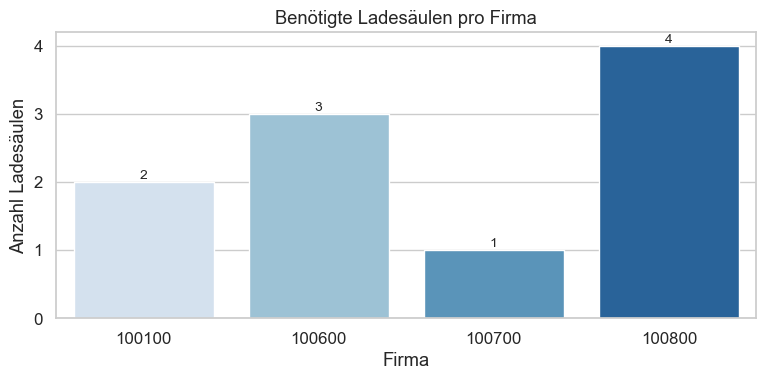

C:\Users\pasca\AppData\Local\Temp\ipykernel_4576\2335291493.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),


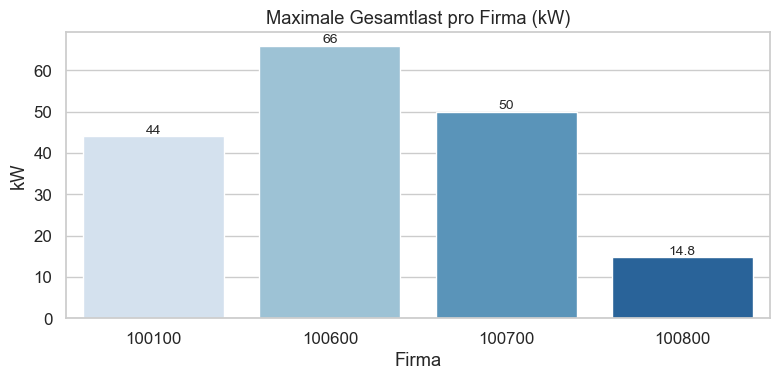

C:\Users\pasca\AppData\Local\Temp\ipykernel_4576\2335291493.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),


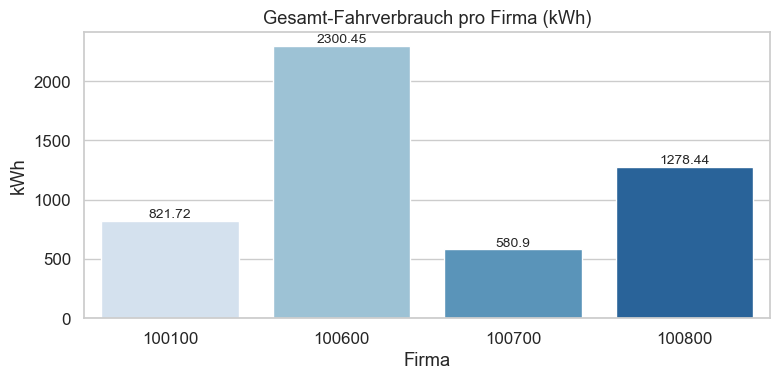

C:\Users\pasca\AppData\Local\Temp\ipykernel_4576\2335291493.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company_id', y='min_SoC', data=df_fahrzeuge, palette="Set2")


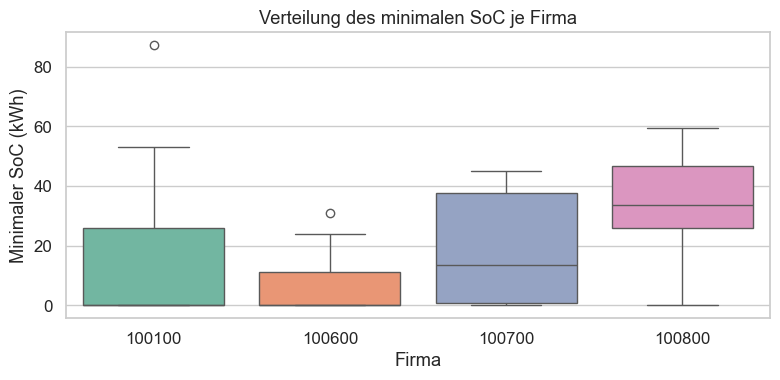

In [10]:
#--------------------------- SCHRITT 9: SEABORN-VISUALISIERUNGEN -------------------

df_firmen_plot = df_firmen.sort_values('company_id')

plt.figure(figsize=(8, 4))
ax1 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),
                  y=df_firmen_plot['chargers_needed'],
                  palette=BAR_PALETTE)
ax1.set_title("Benötigte Ladesäulen pro Firma")
ax1.set_xlabel("Firma")
ax1.set_ylabel("Anzahl Ladesäulen")
for container in ax1.containers:
    ax1.bar_label(container, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
ax2 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),
                  y=df_firmen_plot['max_load_kW'],
                  palette=BAR_PALETTE)
ax2.set_title("Maximale Gesamtlast pro Firma (kW)")
ax2.set_xlabel("Firma")
ax2.set_ylabel("kW")
for container in ax2.containers:
    ax2.bar_label(container, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
ax3 = sns.barplot(x=df_firmen_plot['company_id'].astype(str),
                  y=df_firmen_plot['total_consumption_kWh'],
                  palette=BAR_PALETTE)
ax3.set_title("Gesamt-Fahrverbrauch pro Firma (kWh)")
ax3.set_xlabel("Firma")
ax3.set_ylabel("kWh")
for container in ax3.containers:
    ax3.bar_label(container, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='company_id', y='min_SoC', data=df_fahrzeuge, palette="Set2")
plt.title("Verteilung des minimalen SoC je Firma")
plt.xlabel("Firma")
plt.ylabel("Minimaler SoC (kWh)")
plt.tight_layout()
plt.show()

In [11]:
# ---------------- SCHRITT 10: KONSOLENAUSGABEN ------------------------------
print("\n=== Schritt 10: Konsolenausgaben ===")
print("\n--- FIRMEN-ERGEBNISSE ---")
print(df_firmen)
print("\n--- FAHRZEUGE-ERGEBNISSE (erste 30 Zeilen) ---")
print(df_fahrzeuge.head(30))


=== Schritt 10: Konsolenausgaben ===

--- FIRMEN-ERGEBNISSE ---
   company_id  total_vehicles  electrifiable_vehicles  \
0      100100              10                       4   
1      100600              10                       4   
2      100700              10                       7   
3      100800              10                       9   

   non_electrifiable_vehicles  total_distance_km  charger_power_used  \
0                           6           16848.17                22.0   
1                           6           38720.53                22.0   
2                           3           13312.38                50.0   
3                           1            8093.76                 3.7   

   chargers_needed  max_load_kW  avg_load_kW  total_consumption_kWh  \
0                2         44.0         4.95                 821.72   
1                3         66.0         6.11                2300.45   
2                1         50.0         3.51                 580.90   
3   


=== Schritt 11: Minütliche Visualisierung ===

=== Schritt 11: Minütliche Visualisierung ===
[VISU] Firma 100100: 2 Charger, 22.0 kW

Mapping für Firma 100100 (alte ID -> neue ID):
1107000482 -> 1 (electrifiable=no, reason=Intervall zu lang)
1202581942 -> 2 (electrifiable=yes)
1208573550 -> 3 (electrifiable=no, reason=Intervall zu lang)
1208654863 -> 4 (electrifiable=no, reason=Intervall zu lang)
1209357301 -> 5 (electrifiable=yes)
1209564245 -> 6 (electrifiable=yes)
1312573550 -> 7 (electrifiable=no, reason=Intervall zu lang)
1404653121 -> 8 (electrifiable=no, reason=Ladezeit zu kurz)
1409510685 -> 9 (electrifiable=no, reason=Ladezeit zu kurz)
1409650507 -> 10 (electrifiable=yes)


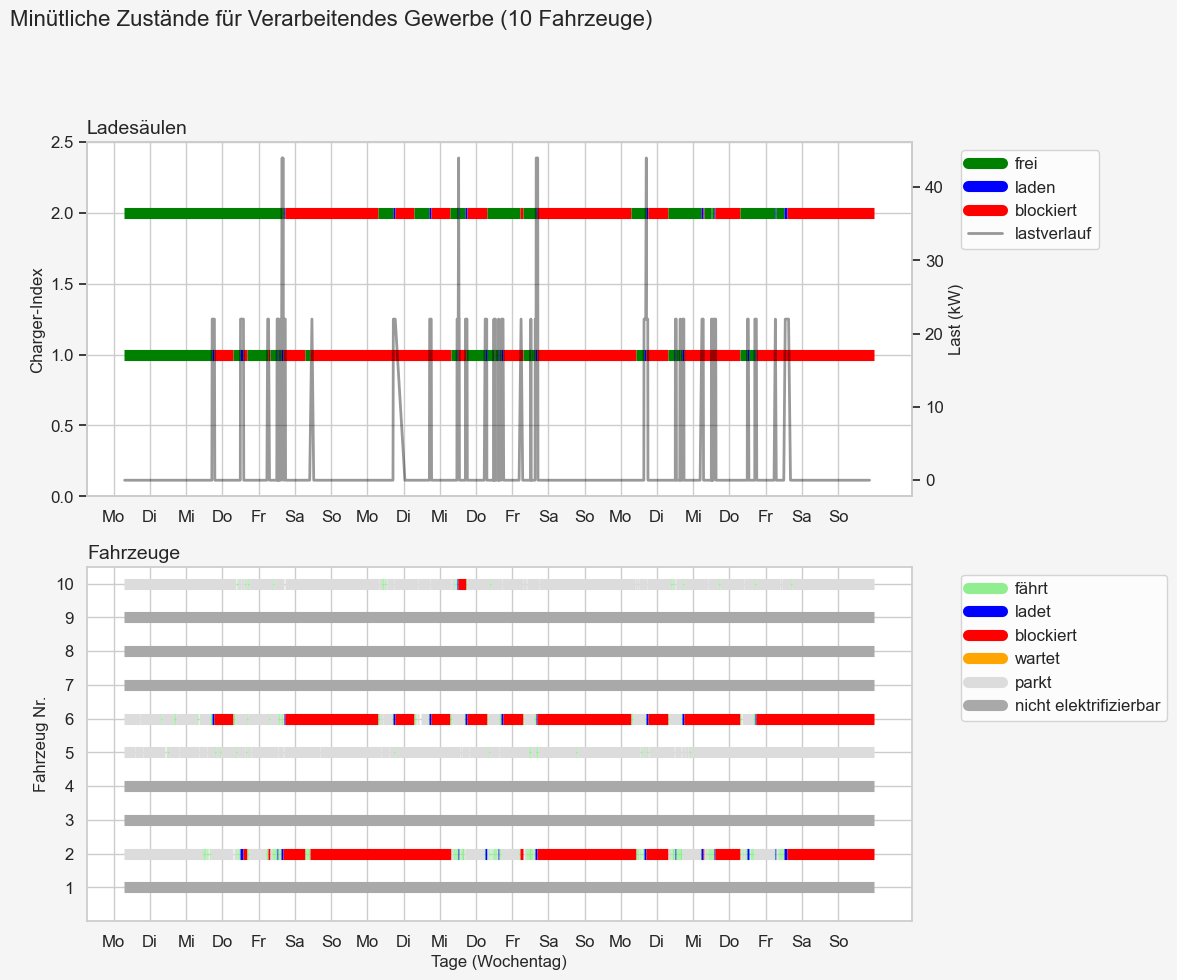

[VISU] Firma 100600: 3 Charger, 22.0 kW

Mapping für Firma 100600 (alte ID -> neue ID):
1106000611 -> 1 (electrifiable=no, reason=Intervall zu lang)
1107000282 -> 2 (electrifiable=no, reason=Intervall zu lang)
1107000292 -> 3 (electrifiable=no, reason=Intervall zu lang)
1202557462 -> 4 (electrifiable=yes)
1202558072 -> 5 (electrifiable=no, reason=Intervall zu lang)
1202650283 -> 6 (electrifiable=yes)
1202654806 -> 7 (electrifiable=yes)
1202655258 -> 8 (electrifiable=no, reason=Intervall zu lang)
1408570341 -> 9 (electrifiable=yes)
1501557421 -> 10 (electrifiable=no, reason=Intervall zu lang)


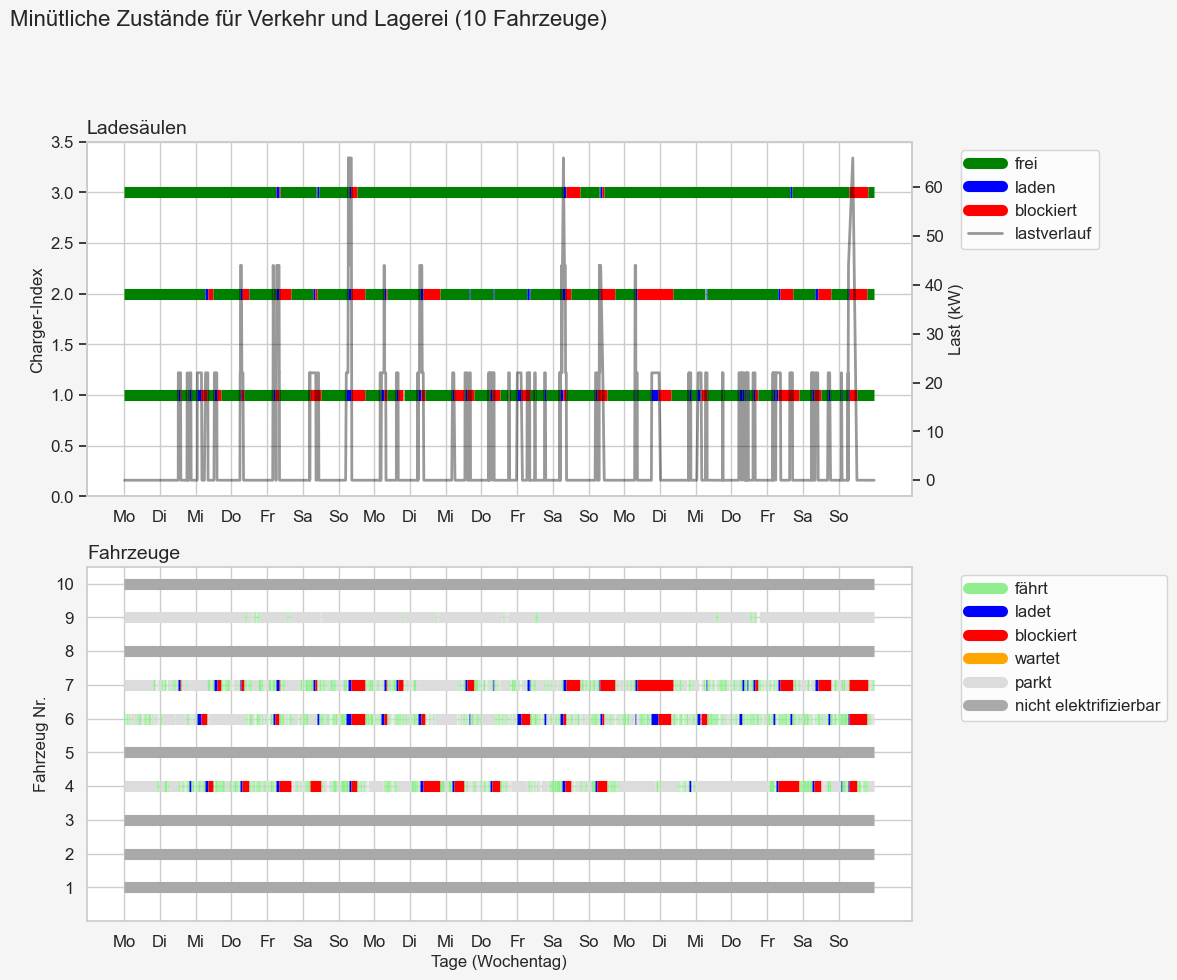

[VISU] Firma 100700: 1 Charger, 50.0 kW

Mapping für Firma 100700 (alte ID -> neue ID):
1106000571 -> 1 (electrifiable=yes)
1106000581 -> 2 (electrifiable=yes)
1205564245 -> 3 (electrifiable=yes)
1208557421 -> 4 (electrifiable=no, reason=Intervall zu lang)
1209573550 -> 5 (electrifiable=no, reason=Intervall zu lang)
1209624569 -> 6 (electrifiable=no, reason=Intervall zu lang)
1401514356 -> 7 (electrifiable=yes)
1401573006 -> 8 (electrifiable=yes)
1401573360 -> 9 (electrifiable=yes)
1405573782 -> 10 (electrifiable=yes)


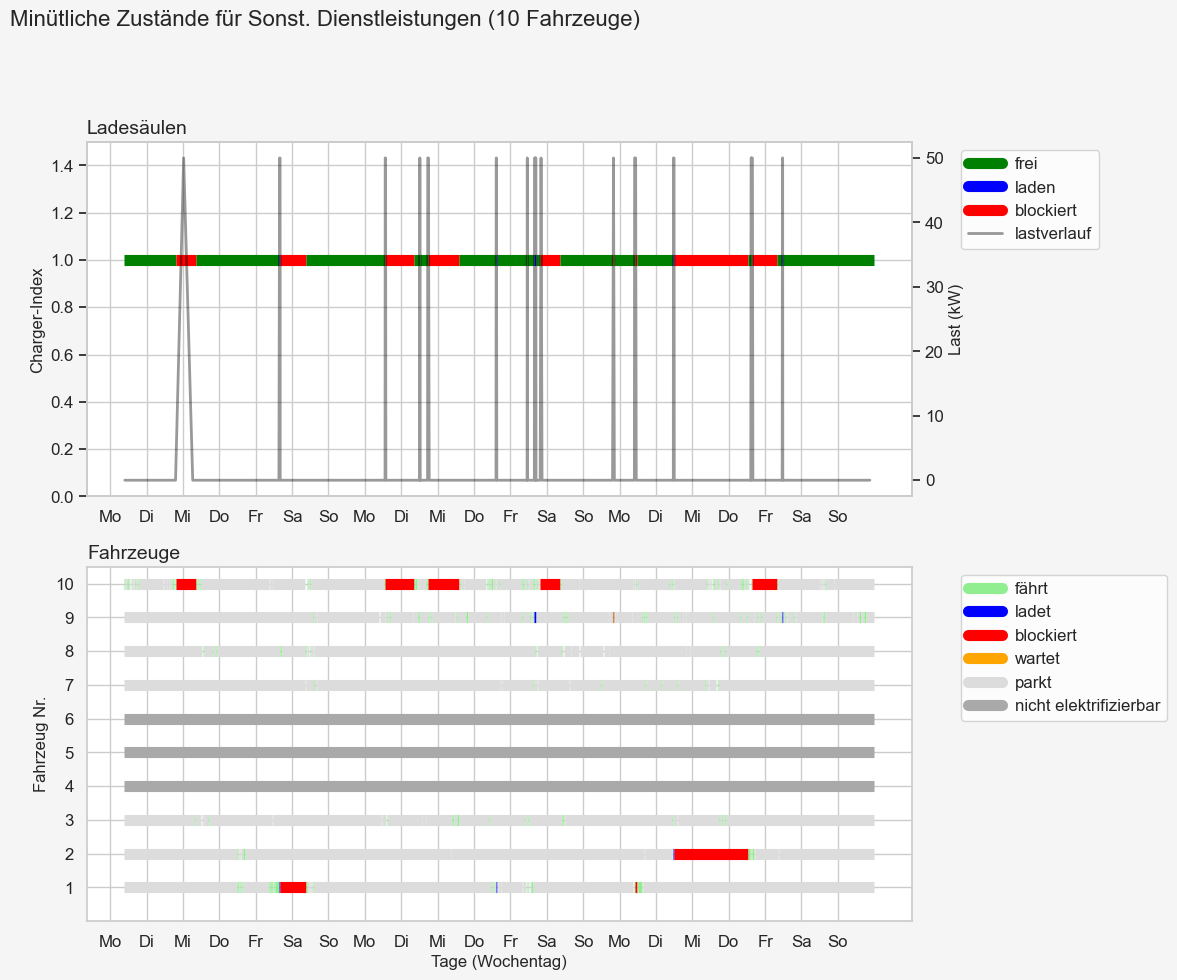

[VISU] Firma 100800: 4 Charger, 3.7 kW

Mapping für Firma 100800 (alte ID -> neue ID):
1106000461 -> 1 (electrifiable=yes)
1106000471 -> 2 (electrifiable=yes)
1106000481 -> 3 (electrifiable=yes)
1106000801 -> 4 (electrifiable=yes)
1106000861 -> 5 (electrifiable=no, reason=Intervall zu lang)
1202563809 -> 6 (electrifiable=yes)
1202564245 -> 7 (electrifiable=yes)
1203570341 -> 8 (electrifiable=yes)
1203624569 -> 9 (electrifiable=yes)
1203642504 -> 10 (electrifiable=yes)


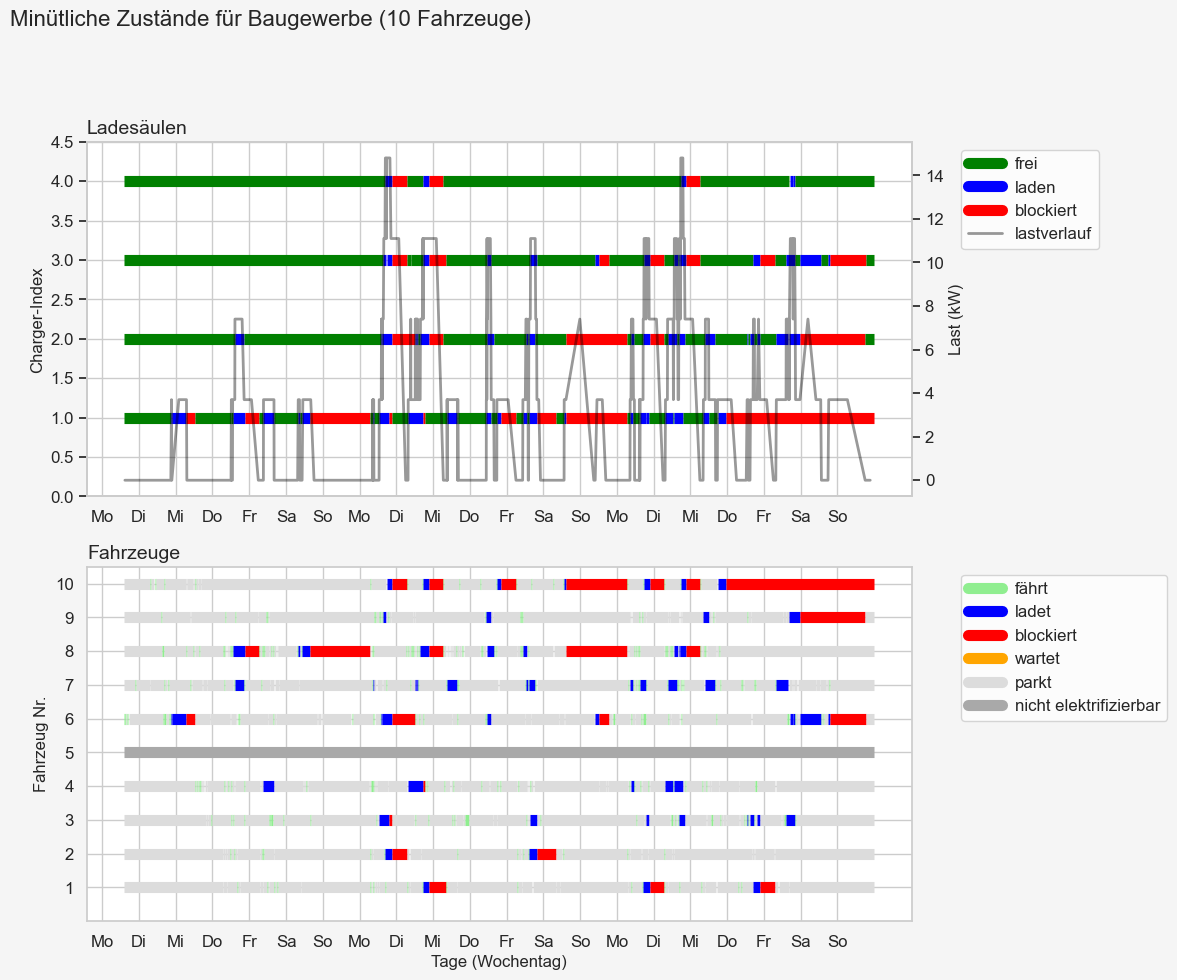


=== Ladesäulen-Ergebnisse: ladesaeulen_ergebnisse.csv geschrieben ===
    week  day  hour  minute  company_id  charger_id  charger_power state  \
0      1    1     7       0      100100  C_100100_1           22.0  frei   
1      1    1     7       0      100100  C_100100_2           22.0  frei   
2      1    1     7       1      100100  C_100100_1           22.0  frei   
3      1    1     7       1      100100  C_100100_2           22.0  frei   
4      1    1     7       2      100100  C_100100_1           22.0  frei   
5      1    1     7       2      100100  C_100100_2           22.0  frei   
6      1    1     7       3      100100  C_100100_1           22.0  frei   
7      1    1     7       3      100100  C_100100_2           22.0  frei   
8      1    1     7       4      100100  C_100100_1           22.0  frei   
9      1    1     7       4      100100  C_100100_2           22.0  frei   
10     1    1     7       5      100100  C_100100_1           22.0  frei   
11     1    1    

In [ ]:
# %%
# ----------------- SCHRITT 11: MINÜTLICHE VISUALISIERUNG ---------------------
"""
Plot für Ladesäulen (Charger) und Fahrzeuge.
Ersetzt 'nicht_elektrifizierbar' => 'nicht elektrifizierbar'
Benennt die Y-Achse in 'Fahrzeug Nr.'
Zeigt auf der X-Achse jetzt alle 21 Tage (Mo, Di, Mi, Do, Fr, Sa, So) wiederholt.
Setzt suptitle linksbündig (ha='left', x=0.0)
Mapping: Falls electrifiable='no', zeige Grund.
"""

all_charger_rows= []

def minute_to_week_day_hour_minute(m: int):
    """Konvertiert Simulationsminute (m=0..∞) in week,day,hour,minute. 1W=10080."""
    w= (m // 10080)+1
    leftover= m % 10080
    d= (leftover // (24*60))+1
    leftover2= leftover % (24*60)
    h= leftover2 // 60
    mm= leftover2 % 60
    return w,d,h,mm

def create_horizontal_segments(df_in, id_col, time_col, state_col):
    """ Aggregiert zusammenhängende Zeitintervalle mit gleichem 'state_col'. """
    if df_in.empty:
        return pd.DataFrame(columns=[id_col,'start_time','end_time','state'])
    segments= []
    for vid, group in df_in.groupby(id_col):
        group= group.sort_values(time_col)
        current_state= None
        seg_start= None
        prev_time= None
        for idx, row in group.iterrows():
            t= row[time_col]
            s= row[state_col]
            if current_state is None:
                current_state= s
                seg_start= t
                prev_time= t
            elif s==current_state:
                prev_time= t
            else:
                segments.append({
                    id_col: vid,
                    'start_time': seg_start,
                    'end_time': prev_time,
                    'state': current_state
                })
                current_state= s
                seg_start= t
                prev_time= t
        if current_state is not None:
            segments.append({
                id_col: vid,
                'start_time': seg_start,
                'end_time': prev_time,
                'state': current_state
            })
    return pd.DataFrame(segments)

def visualize_minutely_seaborn(target_companies):
    """
    Schritt 11:
      - 'nicht_elektrifizierbar' -> 'nicht elektrifizierbar' (Fahrzeugzustand)
      - Y-Achse: 'Fahrzeug Nr.'
      - X-Achse: Mo, Di, Mi, Do, Fr, Sa, So über 21 Tage (3 Wochen)
      - Überschrift: linksbündig (ha='left') => suptitle
      - Mapping: Bei electrifiable='no', zeige reason
    """
    global all_charger_rows
    all_charger_rows.clear()

    # Farben und Mappings
    charger_color_map= {
        'frei':'green','laden':'blue','blockiert':'red'
    }
    vehicle_color_map= {
        'fährt':'lightgreen',
        'ladet':'blue',
        'blockiert':'red',
        'wartet':'orange',
        'parkt':'gainsboro',
        'nicht elektrifizierbar':'darkgrey'  # Leerzeichen
    }

    company_names= {
        100100: "Verarbeitendes Gewerbe",
        100600: "Verkehr und Lagerei",
        100700: "Sonst. Dienstleistungen",
        100800: "Baugewerbe"
    }

    print("\n=== Schritt 11: Minütliche Visualisierung ===")

    for company in target_companies:
        if company not in company_sim_params:
            n_chargers=5
            pwr=11.0
        else:
            n_chargers, pwr= company_sim_params[company]

        print(f"[VISU] Firma {company}: {n_chargers} Charger, {pwr} kW")

        # Evtl. DF
        ev_f= company_events_map.get(company, pd.DataFrame())
        iv_f= company_intervals_map.get(company, pd.DataFrame())
        drv_f= company_driving_map.get(company, pd.DataFrame())

        # IDs
        v_ids_firma= iv_f['vehicle_id'].unique() if not iv_f.empty else []
        if len(v_ids_firma)==0:
            print(f"[VISU] Firma {company}: Keine Fahrzeuge => skip.")
            continue

        # Spalte in df_fahrzeuge, um reason auslesen zu können
        firm_veh= df_fahrzeuge[df_fahrzeuge['company_id']==company]
        non_elec_ids= firm_veh[firm_veh['electrifiable']=='no']['vehicle_id'].unique()
        elec_ids    = firm_veh[firm_veh['electrifiable']=='yes']['vehicle_id'].unique()

        # Simulation => record_minutely=True
        sim_result= simulate_firm(
            company_id= company,
            n_chargers= n_chargers,
            charger_power= pwr,
            events_data= ev_f,
            intervals_data= iv_f,
            driving_data= drv_f,
            record_minutely= True,
            active_vehicles= elec_ids
        )
        minute_df= sim_result['minute_log']
        vehicle_df= sim_result['vehicle_min_log']
        load_timeline= sim_result['load_timeline']

        if minute_df.empty and len(non_elec_ids)==0:
            print(f"[VISU] Firma {company}: Keine minütlichen Logs => skip.")
            continue

        if not minute_df.empty and 'charger_index' not in minute_df.columns:
            print(f"[VISU] Firma {company}: charger_index fehlt => skip.")
            continue

        # Charger -> index+1
        if not minute_df.empty:
            minute_df['charger_index']= minute_df['charger_index']+1

        # Charger => globale CSV
        for idxC, rowC2 in minute_df.iterrows():
            m_int= int(rowC2['minute'])
            (w_, d_, h_, mm_)= minute_to_week_day_hour_minute(m_int)
            c_idx= int(rowC2['charger_index'])
            c_state= rowC2['charger_state']
            ld_   = rowC2['load_kW']
            charger_id= f"C_{company}_{c_idx}"
            all_charger_rows.append({
                'week': w_,'day': d_,'hour':h_,'minute':mm_,
                'company_id': company,
                'charger_id': charger_id,
                'charger_power': pwr,
                'state': c_state,
                'load_kW': ld_
            })

        # 1) Aus vehicle_df => horizontale Segmente
        seg_elec= create_horizontal_segments(vehicle_df, 'vehicle_id','minute','vehicle_state')

        # 2) Für non-elec => "nicht elektrifizierbar"
        if not minute_df.empty:
            t_min= int(minute_df['minute'].min())
            t_max= int(minute_df['minute'].max())
        else:
            t_min, t_max= 0,1

        rows_non_elec=[]
        for vN in non_elec_ids:
            rows_non_elec.append({
                'vehicle_id': vN,
                'start_time': t_min,
                'end_time': t_max,
                'state': 'nicht elektrifizierbar'
            })
        df_non_elec= pd.DataFrame(rows_non_elec)

        seg_vehicles= pd.concat([seg_elec, df_non_elec], ignore_index=True)

        # => Falls ein "elec_ids" gar nicht in seg_vehicles => parkt
        for vE in elec_ids:
            subset_ = seg_vehicles[seg_vehicles['vehicle_id']==vE]
            if subset_.empty:
                seg_vehicles= seg_vehicles.append({
                    'vehicle_id': vE,
                    'start_time': t_min,
                    'end_time': t_max,
                    'state': 'parkt'
                }, ignore_index=True)

        # ID-Remapping
        all_ids= sorted(seg_vehicles['vehicle_id'].unique())
        map_dict= {}
        newID=1
        for oldID in all_ids:
            map_dict[oldID]= newID
            newID +=1

        # => Mapping-Ausgabe
        print(f"\nMapping für Firma {company} (alte ID -> neue ID):")
        for old in all_ids:
            new_= map_dict[old]
            row_ = firm_veh[firm_veh['vehicle_id']== old]
            if not row_.empty:
                eflag= row_['electrifiable'].iloc[0]
                reason= row_['reason'].iloc[0] if 'reason' in row_.columns else ""
                if eflag=="no":
                    print(f"{old} -> {new_} (electrifiable=no, reason={reason})")
                else:
                    print(f"{old} -> {new_} (electrifiable=yes)")
            else:
                print(f"{old} -> {new_} (unknown)")

        seg_vehicles['vehicle_id']= seg_vehicles['vehicle_id'].map(map_dict)

        # => charger_segments
        if not minute_df.empty:
            charger_segments= create_horizontal_segments(minute_df, 'charger_index','minute','charger_state')
            charger_segments['start_day']= charger_segments['start_time']/1440
            charger_segments['end_day']  = charger_segments['end_time']/1440
        else:
            charger_segments= pd.DataFrame()

        seg_vehicles['start_day']= seg_vehicles['start_time']/1440
        seg_vehicles['end_day']  = seg_vehicles['end_time']/1440

        # X-Achse: 21 Tage -> Mo..So (wiederholt für 3 Wochen)
        days_of_week = ["Mo","Di","Mi","Do","Fr","Sa","So"]
        xticks = range(21)
        xlabels = [days_of_week[i % 7] for i in xticks]

        fig, axes= plt.subplots(2,1, figsize=(FIG_WIDTH,FIG_HEIGHT))
        fig.patch.set_facecolor("whitesmoke")

        # OBERER => Charger
        axes[0].set_title("Ladesäulen", fontsize=14, loc='left')
        if not charger_segments.empty:
            for idxch, rowch in charger_segments.iterrows():
                ccol= charger_color_map.get(rowch['state'],'black')
                axes[0].hlines(
                    y= rowch['charger_index'],
                    xmin= rowch['start_day'],
                    xmax= rowch['end_day'],
                    color= ccol,
                    linewidth=8,
                    zorder=3
                )
        axes[0].set_ylabel("Charger-Index", fontsize=12)
        axes[0].set_xticks(xticks)
        axes[0].set_xticklabels(xlabels)

        if not charger_segments.empty:
            max_c= charger_segments['charger_index'].max()
        else:
            max_c=1
        axes[0].set_ylim(bottom=0, top=max_c+0.5)

        # Lastkurve
        load_timeline= sim_result['load_timeline']
        if SHOW_LOAD_CURVE and load_timeline:
            ax_load= axes[0].twinx()
            load_times=[]
            load_vals=[]
            for (st_,en_,ld_) in load_timeline:
                mid= (st_+en_)/2/1440
                load_times.append(mid)
                load_vals.append(ld_)
            if load_times:
                ax_load.plot(load_times, load_vals,
                             color=LOAD_CURVE_COLOR, linewidth=LOAD_CURVE_LINEWIDTH,
                             alpha=0.4, label="Lastverlauf")
                ax_load.grid(False, axis='y')
                ax_load.set_ylabel("Last (kW)", fontsize=12)

        # Legende für Ladesäulen
        c_handles= [
            plt.Line2D([0],[0], color='green', lw=8, label='frei'),
            plt.Line2D([0],[0], color='blue', lw=8, label='laden'),
            plt.Line2D([0],[0], color='red', lw=8, label='blockiert'),
            plt.Line2D([0],[0], color=LOAD_CURVE_COLOR, lw=LOAD_CURVE_LINEWIDTH, alpha=0.4, label='lastverlauf')
        ]
        axes[0].legend(handles=c_handles, loc='upper left', bbox_to_anchor=(1.05,1))

        # UNTERER => Fahrzeuge
        axes[1].set_title("Fahrzeuge", fontsize=14, loc='left')
        if not seg_vehicles.empty:
            for idxv, rowv in seg_vehicles.iterrows():
                col_= vehicle_color_map.get(rowv['state'],'black')
                axes[1].hlines(
                    y= rowv['vehicle_id'],
                    xmin= rowv['start_day'],
                    xmax= rowv['end_day'],
                    color= col_,
                    linewidth=8,
                    zorder=3
                )

        axes[1].set_xlabel("Tage (Wochentag)", fontsize=12)
        axes[1].set_ylabel("Fahrzeug Nr.", fontsize=12)

        axes[1].set_xticks(xticks)
        axes[1].set_xticklabels(xlabels)

        if not seg_vehicles.empty:
            max_v= seg_vehicles['vehicle_id'].max()
        else:
            max_v=1
        axes[1].set_ylim(bottom=0, top=max_v+0.5)
        axes[1].set_yticks(range(1, max_v+1))

        # Legende für Fahrzeuge
        v_handles= [
            plt.Line2D([0],[0], color='lightgreen', lw=8, label='fährt'),
            plt.Line2D([0],[0], color='blue',       lw=8, label='ladet'),
            plt.Line2D([0],[0], color='red',        lw=8, label='blockiert'),
            plt.Line2D([0],[0], color='orange',     lw=8, label='wartet'),
            plt.Line2D([0],[0], color='gainsboro',  lw=8, label='parkt'),
            plt.Line2D([0],[0], color='darkgrey',   lw=8, label='nicht elektrifizierbar')
        ]
        axes[1].legend(handles=v_handles, loc='upper left', bbox_to_anchor=(1.05,1))

        comp_label= company_names.get(company, str(company))
        fig.suptitle(
            f"Minütliche Zustände für {comp_label} ({len(v_ids_firma)} Fahrzeuge)",
            fontsize=16,
            ha='left',
            x=0.0
        )

        plt.tight_layout(rect=[0,0,0.85,0.93])
        plt.show()

# Ausführung:
print("\n=== Schritt 11: Minütliche Visualisierung ===")
visualize_minutely_seaborn(TARGET_COMPANIES)

# => CSV "ladesaeulen_ergebnisse"
df_charger_states= pd.DataFrame(all_charger_rows)
if not df_charger_states.empty:
    df_charger_states.to_csv("ladesaeulen_ergebnisse.csv", sep=";", index=False)
    print("\n=== Ladesäulen-Ergebnisse: ladesaeulen_ergebnisse.csv geschrieben ===")
    print(df_charger_states.head(50))
else:
    print("\n*** HINWEIS: Keine Ladesäulen-Minuten-Logs => ladesaeulen_ergebnisse.csv bleibt leer. ***")